<a href="https://colab.research.google.com/github/DinneRatj/Vector-Embedding-Model/blob/main/LMCL%26SSL__2nd_Run_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imporing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

#Added so that the random numbers are always the same when the program is run, so the results are always the same
np.random.seed(1234)
torch.manual_seed(1234)

In [ ]:
#Mounting to Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading data
dataset = pd.read_csv("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
dataset

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [ ]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

#Input >14 Numerical coloums and 4 Categorical coloums
#Output > 1 Categorical coloum

In [ ]:
#Processing columns
scaler = StandardScaler()

#Numerical
#Convert our numerical columns to tensors
numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)

#Fixed how to use scaler
numerical_data = scaler.fit_transform(numerical_data)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
#Convert the types for categorical columns to category
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

#Convert data in the four categorical columns into numpy arrays and then stack all the columns horizontally 
st = dataset['state'].cat.codes.values
ip = dataset['international plan'].cat.codes.values
vm = dataset['voice mail plan'].cat.codes.values
ac = dataset['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
#Convert the output numpy array into a tensor object
dataset[outputs] = dataset[outputs].astype(int)
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs = outputs.long()

#Print Outputs
print(numerical_data)
print(numerical_data.dtype)
print(numerical_data.shape)
print('_' * 75)

print(categorical_data)
print(categorical_data.dtype)
print(categorical_data.shape)
print('_' * 75)

tensor([[ 1.2349,  1.5668,  0.4766,  ..., -0.6012, -0.0857, -0.4279],
        [ 1.3079, -0.3337,  1.1245,  ..., -0.6012,  1.2412, -0.4279],
        [-0.5918,  1.1683,  0.6760,  ...,  0.2115,  0.6972, -1.1882],
        ...,
        [-0.5918,  0.0188,  0.4268,  ...,  0.6179,  1.3871,  0.3324],
        [-0.5918,  0.6248,  0.2275,  ...,  2.2434, -1.8770,  0.3324],
        [ 1.2349,  1.0030,  0.6261,  ..., -0.1948,  1.2412, -1.1882]])
torch.float32
torch.Size([3333, 14])
___________________________________________________________________________
tensor([[16,  0,  1,  1],
        [35,  0,  1,  1],
        [31,  0,  0,  1],
        ...,
        [39,  0,  0,  2],
        [ 6,  1,  0,  2],
        [42,  0,  1,  1]])
torch.int64
torch.Size([3333, 4])
___________________________________________________________________________


In [ ]:
numerical_data.shape

torch.Size([3333, 14])

In [ ]:
#Dividing dataset into Training, Valid and Test
total_records = 3333

train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)

numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]

categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]

train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

#Print divide dataset
print(train_records)
print(valid_records)
print(test_records)

1999
666
666


In [ ]:
#Define a class named Model, which will be used to train the model
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 100) #Numerical
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)

# =============================================================================================
#weights 1 and 2 don't exist in this model because they already exist
#as the self.centers attribute in the LMC_Loss model in model_utils.py.
# =============================================================================================
        
        #Categorical
        self.layer1_1 = nn.Embedding(51, 5) #51 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5) #3 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)

        #Decoder
        self.decoder_categorical_1 = nn.Linear(120,51)
        self.decoder_categorical_2 = nn.Linear(120,2)
        self.decoder_categorical_3 = nn.Linear(120,2)
        self.decoder_categorical_4 = nn.Linear(120,3)
                
        self.decoder_numerical = nn.Linear(120,14)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
               
        #Decoder
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
        
        #Decoder
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)

        categorical_1_decoded = self.decoder_categorical_1(x2)
        categorical_2_decoded = self.decoder_categorical_2(x2)
        categorical_3_decoded = self.decoder_categorical_3(x2)
        categorical_4_decoded = self.decoder_categorical_4(x2)
            
        numerical_decoded = self.decoder_numerical(x2)
        
        return emb, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, x2

In [ ]:
model = Model()
print(model.decoder_numerical)

Linear(in_features=120, out_features=14, bias=True)


In [ ]:
!cp /content/drive/MyDrive/model_lmcl.py /content

In [ ]:
# =============================================================================================
#loss function is replaced by using Large Margin Cosine (LMC) Loss implementation
#in the following YirongMao repo: https://github.com/YirongMao/softmax_variants
#
#LMC Loss is a loss function that in theory will be implemented from the start.
#Paper LMC Loss: https://arxiv.org/abs/1801.09414
#
#Cosine Embedding Loss which was used was not actually the same mathematical as LMC Loss,
#therefore the implementation was replaced with the implementation of YirongMao 
# =============================================================================================
# =============================================================================================
#Added a new loss with the LMCLoss library from YirongMao. Cross entropy loss persists,
#because YirongMao's LMCLoss implementation still utilizes Pytorch's original Cross Entropy Loss.
#Check the implementation method at: https://github.com/YirongMao/softmax_variants/blob/master/train_mnist_LMCL.py
#
#margin (parameter m) uses a value of 0.35,
#according to the results of research from the original LMCLoss paper which found that the optimal value was 0.35 or 4.
# =============================================================================================
import model_lmcl

lmcl_loss = model_lmcl.LMCL_loss(num_classes=2, feat_dim=120, m=0.35)
# =============================================================================================
#For cross entropy loss, weight parameter was added,
#because it turned out to be imbalance data (not churn data is much more than churn, with a ratio of around 85:15).
#This imbalance data causes the prediction results for the churn class to be not good.
#The solution is to use the weight parameter in the cross entropy loss,
#so the penalty for being wrong in the churn class is much greater than for being wrong in the not churn class.
#Penalty is increased by the inverse ratio of the ratio of the amount of data (15:85)
#===============================================================================================
#Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))

In [ ]:
#Load training model
model.load_state_dict(torch.load("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCL&SSL.pth".format(churn_percentage)))
lmcl_loss.load_state_dict(torch.load("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCLOSS&SSL.pth".format(churn_percentage)))

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    x1, c1, c2, c3, c4, n1, x3 = model(numerical_test_data, categorical_test_data)

In [ ]:
#Creating predictions
with torch.no_grad():
    test, test_categorical_1_decoded, test_categorical_2_decoded, test_categorical_3_decoded, test_categorical_4_decoded, test_numerical_decoded, test_embed = model(numerical_test_data, categorical_test_data)
    logits, mlogits = lmcl_loss(test_embed, test_outputs)
    test_loss = loss_function(mlogits, test_outputs)
    total_test_loss = test_loss
print(f'Loss: {total_test_loss:.8f}')

Loss: 1.10897565


In [ ]:
#=============================================================================================
#the main result seen is the F1 Score, because
#the misleading accuracy metric is used for imbalance data
#=============================================================================================
from sklearn.metrics import f1_score

test_val = np.argmax(logits, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

[[492  67]
 [ 23  86]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       559
           1       0.56      0.79      0.66       109

    accuracy                           0.87       668
   macro avg       0.76      0.83      0.79       668
weighted avg       0.89      0.87      0.87       668

Accuracy:  0.8652694610778443
F1 Score:  0.7863448334683782


In [ ]:
test_data = dataset[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = dataset[0:train_records]
train_data = train_data.reset_index()

In [ ]:
with torch.no_grad():
    x1, c1, c2, c3, c4, n1, x3 = model(numerical_test_data, categorical_test_data)

In [ ]:
embedding = x1.tolist()

In [ ]:
x = embedding

In [ ]:
#==========================================================================
#Embedding visualization was changed from PCA to t-SNE because
#the results of PCA visualization were not representative.
#Paper t-SNE: https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf
#==========================================================================
tsne = TSNE(n_components=2, verbose=1, perplexity=600, n_iter=1000)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 667 nearest neighbors...
[t-SNE] Indexed 668 samples in 0.001s...
[t-SNE] Computed neighbors for 668 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 668 / 668
[t-SNE] Mean sigma: 5.995789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.389000
[t-SNE] KL divergence after 1000 iterations: 0.022029


In [ ]:
finalDf = pd.concat([principalDf, test_data[['churn']]], axis = 1)

finalDf0 = finalDf[finalDf['churn']==0]
finalDf1 = finalDf[finalDf['churn']==1]

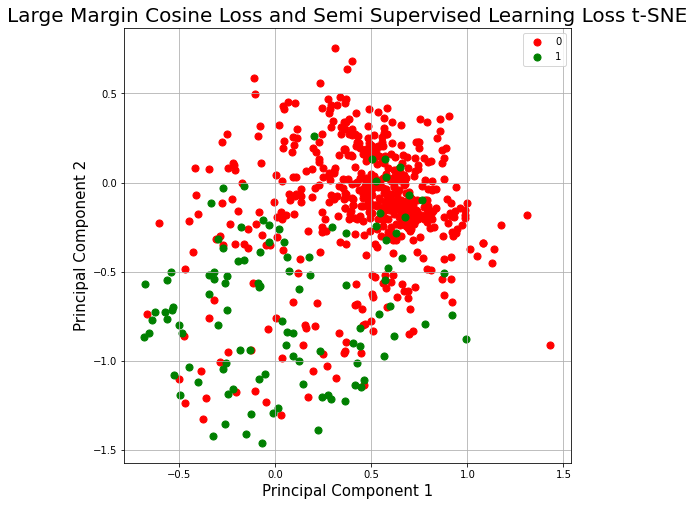

In [ ]:
#Visualisasi embedding churn dan not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Large Margin Cosine Loss and Semi Supervised Learning Loss t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

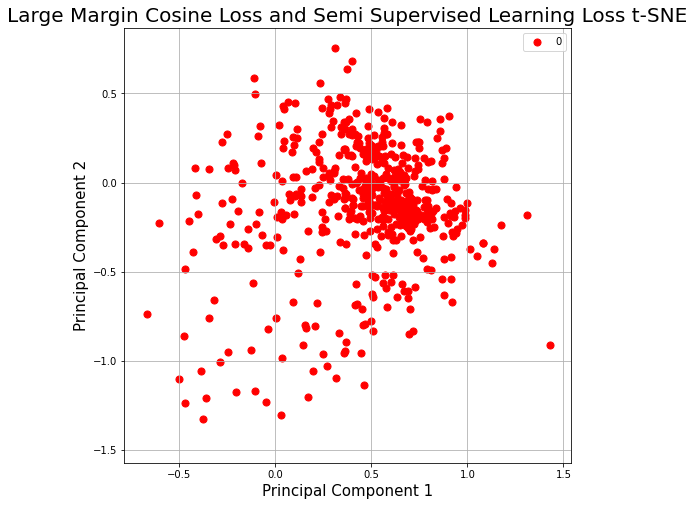

In [ ]:
#Visualisasi embedding not churn only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Large Margin Cosine Loss and Semi Supervised Learning Loss t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0]
colors = ['r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['churn'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

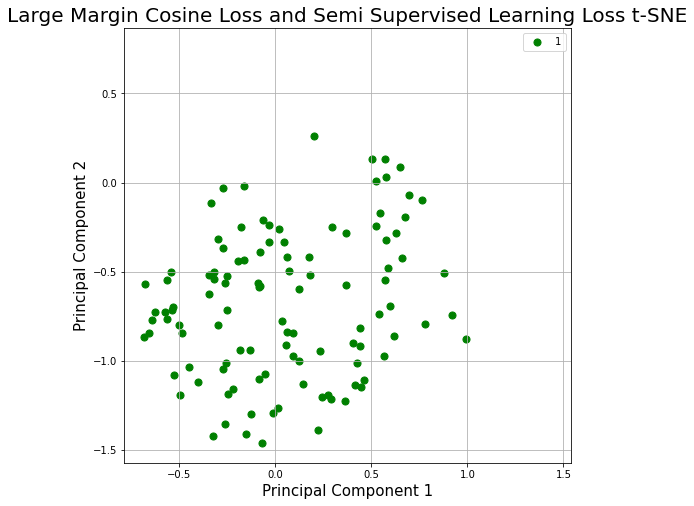

In [ ]:
#Visualisasi embedding churn only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Large Margin Cosine Loss and Semi Supervised Learning Loss t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [1]
colors = ['g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['churn'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#===========================================================================
#In addition to the F1 Score, it is also reported that the ratio
#of the distance between intra-cluster embedding and inter-cluster
#embedding distance is the distance between the embedding in a class
#to the vector in the middle of the class (centroid/center).
#Distance is measured by Cosine similarity.
#The greater the cosine similarity number, the smaller the distance measured.
#inter-cluster embedding distance is the distance between
#embedding in one class to the center of another class (centroid/center).
#Distance is also measured by Cosine similarity.
#Because of the definition of cosine similarity,
#the greater the inter:intra ratio, the better the algorithm's performance.
#============================================================================
notchurn_emb = x1[test_outputs==0]
sum_notchurn = x1[test_outputs==0].sum(dim=0)
center_notchurn = sum_notchurn/sum_notchurn.norm(p=2)
center_notchurn = center_notchurn.unsqueeze(0)

churn_emb = x1[test_outputs==1]
sum_churn = x1[test_outputs==1].sum(dim=0)
center_churn = sum_churn/sum_churn.norm(p=2)
center_churn = center_churn.unsqueeze(0)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

notchurn_centnotchurn_sim = cos(notchurn_emb, center_notchurn).mean()
notchurn_centchurn_sim = cos(notchurn_emb, center_churn).mean()
churn_centchurn_sim = cos(churn_emb, center_churn).mean()
churn_centnotchurn_sim = cos(churn_emb, center_notchurn).mean()

print("emb not churn, center not churn (not churn intra-cluster): ", notchurn_centnotchurn_sim)
print("emb not churn, center churn (not churn inter-cluster): ", notchurn_centchurn_sim)
print("emb churn, center churn (churn intra-cluster): ", churn_centchurn_sim)
print("emb churn, center not churn (churn inter-cluster): ", churn_centnotchurn_sim)

print("not churn inter-intra cluster ratio: ", notchurn_centnotchurn_sim/notchurn_centchurn_sim)
print("churn inter-intra cluster ratio: ", churn_centchurn_sim/churn_centnotchurn_sim)

emb not churn, center not churn (not churn intra-cluster):  tensor(0.5844)
emb not churn, center churn (not churn inter-cluster):  tensor(0.4227)
emb churn, center churn (churn intra-cluster):  tensor(0.6865)
emb churn, center not churn (churn inter-cluster):  tensor(0.5682)
not churn inter-intra cluster ratio:  tensor(1.3825)
churn inter-intra cluster ratio:  tensor(1.2082)
